In [1]:
# Внимание!!! Важно, что бы файлы с данными и исполняемый файл находились в одной папке, 
# тогда пути к тестовым и тренировочным наборам будут содержать только имена файлов.
# 
# В пути к тренировочным и тестовым данным запрежается использовать абсалютную адресацию, 
# то есть адресацию, в которой присутствуют имена папок. Путь должен содержать только имя файла.
#
# Напоминание: под моделью машинного обучения понимаются все действия с исходными данными, 
# которые необходимо произвести, что бы сопоставить признаки целевому значению.

### Область работы 1 (библиотеки)

In [285]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.datasets import load_iris

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score 
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, TunedThresholdClassifierCV, FixedThresholdClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB 

import sklearn
#pip install --upgrade scikit-learn
sklearn.__version__

'1.5.2'

### Область работы 2 (поиск  модели .... )

In [306]:
# Данный блок(и) НЕ выполняются преподавателем в области 2
# блок(и) предназначены для поиска лучшей модели 
# должен быть понятен и очевиден отбор параметров модели
# 
# Запрещается размещать данные блоки за пределами обасти 2
# Все блоки данной области должны быть выполнены
#
# ЗАПРЕЩАЕТСЯ ИСПОЛЬЗОВАТЬ ТЕСТОВЫЙ НАБОР
#
# Путь к тренировочному набору
# 
path_train = 'train.csv'
path_test = 'test.csv'

train_df = pd.read_csv(path_train).dropna() #сразу выкидывааем пустые строки
test_df = pd.read_csv(path_test)
print(train_df.keys(), "количество фич: ", len(train_df.keys())-1)
print(train_df.info())  # Общая информация
print(train_df.describe())  # Статистическая сводка

train_df['quality'] = train_df['quality'].apply(lambda x: 1 if x >= 7 else 0)
print(train_df['quality'].value_counts())
#Делаем вывод, что классы сильно различаются по размеру, глянем распределение

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object') количество фич:  11
<class 'pandas.core.frame.DataFrame'>
Index: 1291 entries, 0 to 1294
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1291 non-null   float64
 1   volatile acidity      1291 non-null   float64
 2   citric acid           1291 non-null   float64
 3   residual sugar        1291 non-null   float64
 4   chlorides             1291 non-null   float64
 5   free sulfur dioxide   1291 non-null   float64
 6   total sulfur dioxide  1291 non-null   float64
 7   density               1291 non-null   float64
 8   pH                    1291 non-null   float64
 9   sulphates             1291 non-null   float64
 10  alcohol               1291 non-null

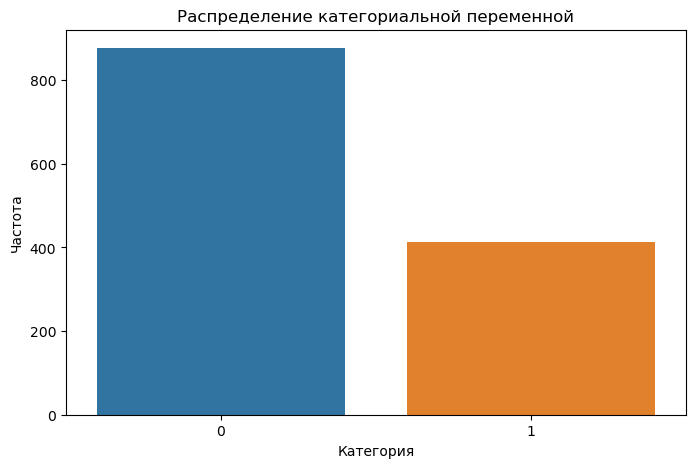

In [308]:
plt.figure(figsize=(8, 5))
sns.countplot(x='quality', data=train_df)
plt.title('Распределение категориальной переменной')
plt.xlabel('Категория')
plt.ylabel('Частота')
plt.show()



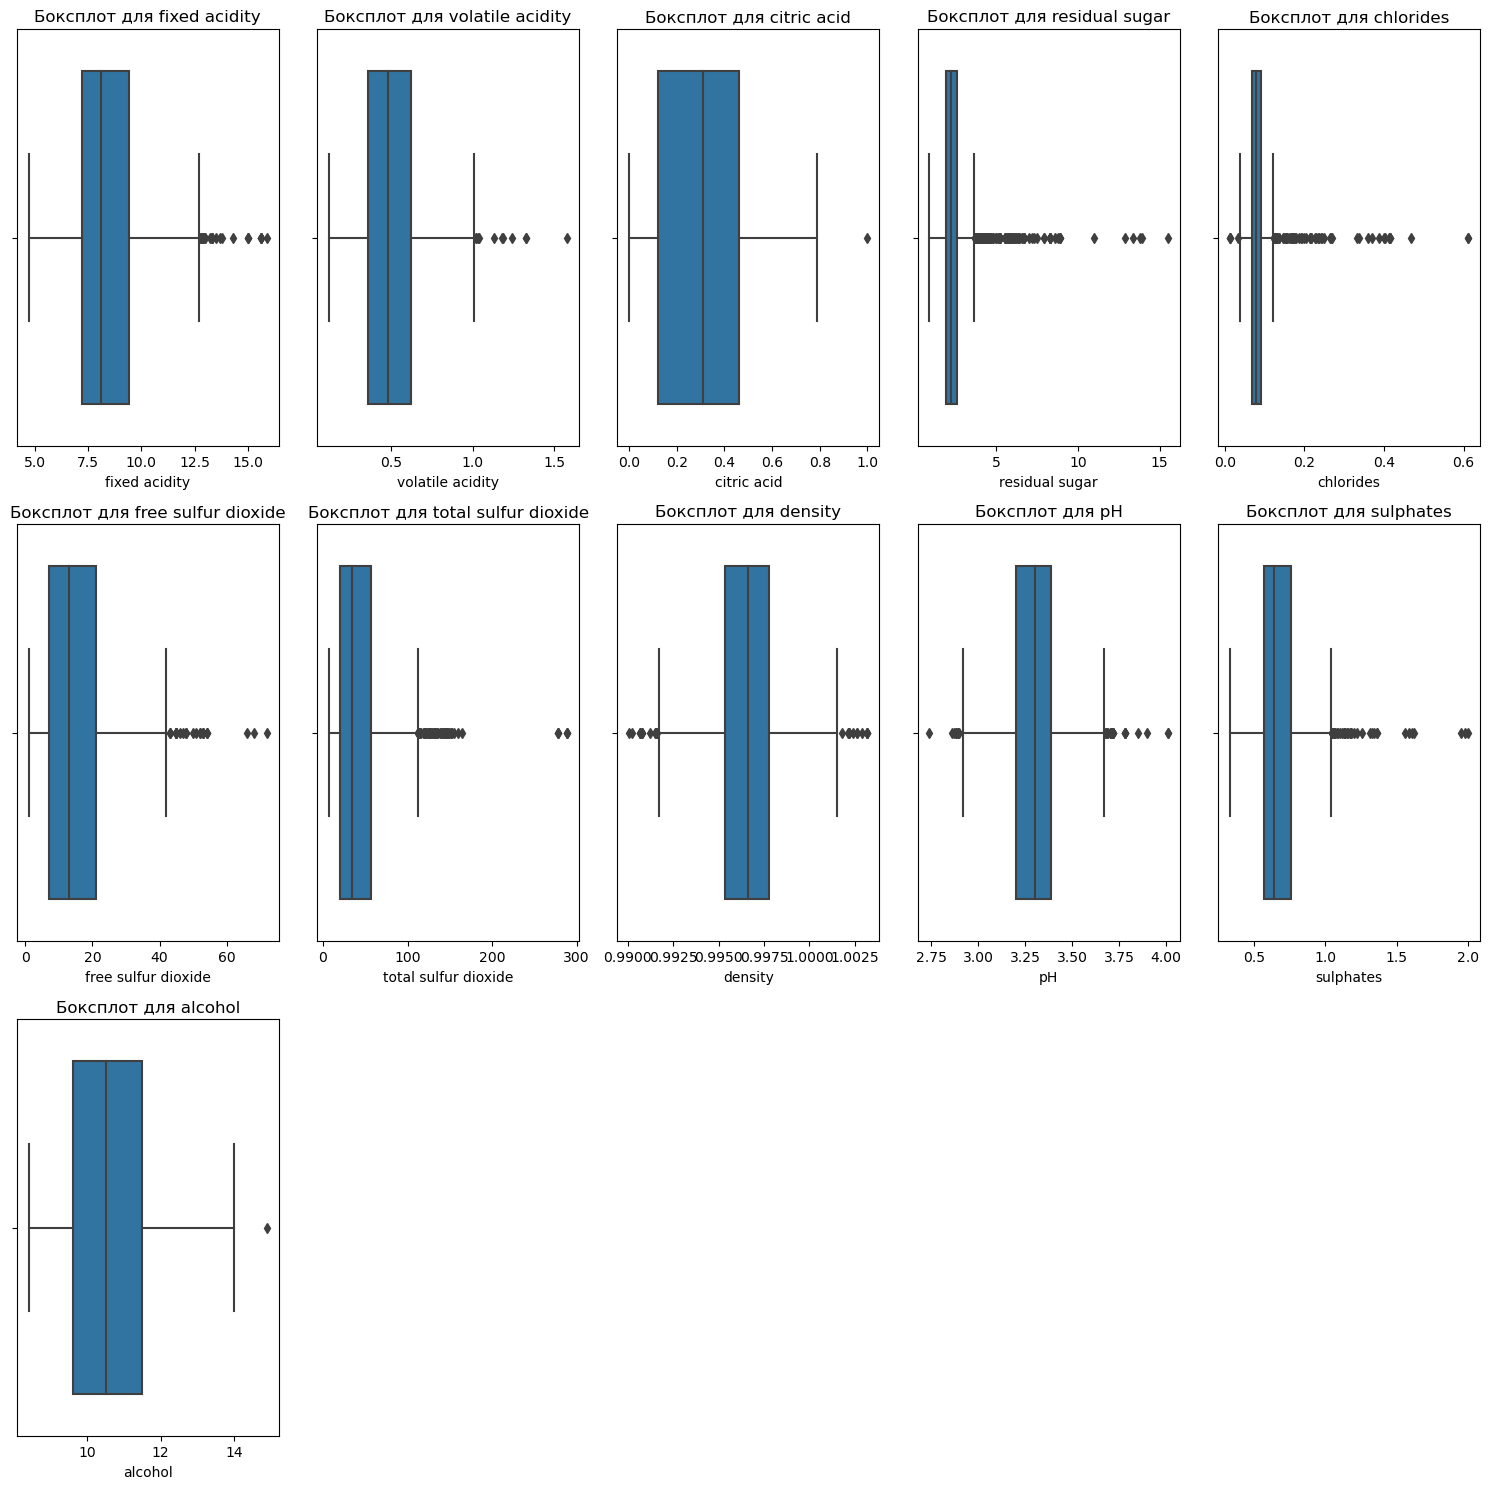

In [310]:
#Посмотрим на выбросы

numerical_columns = train_df.select_dtypes(include='number').columns

# Устанавливаем размеры графиков
n_cols = 5  # Количество колонок в сетке
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols  # Количество строк в сетке
numerical_columns = [col for col in numerical_columns if col != 'quality']

# Создаем подграфики
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Плоский массив для доступа к подграфикам
axes = axes.flatten()

# Для каждой числовой переменной создаем боксплот
for i, column in enumerate(numerical_columns):
    sns.boxplot(x=train_df[column], ax=axes[i])
    axes[i].set_title(f'Боксплот для {column}')
    
# Убираем пустые подграфики, если они есть
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#делаем вывод, что колонки по типу residual sugar и chlorides имеют большое колиечство выбросов, что может мешать обучению модели
#50% выбросов это сильно, как и 100% содержание citric acid, попробуем сначала ничего не делать:))

In [365]:
# Определяем функцию для замены выбросов на границы
def cap_outliers(df):
    # Обходим все колонки в датафрейме
    for column in df.columns:
        Q1 = df[column].quantile(0.25)  # 1-й квартиль
        Q3 = df[column].quantile(0.75)  # 3-й квартиль
        IQR = Q3 - Q1  # Интерквартильный диапазон

        # Вычисляем границы
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Заменяем выбросы на границы
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    
    return df

# Применяем функцию к датафрейму
train_data_cleaned = cap_outliers(train_df.drop('quality', axis = 1))

In [367]:
train_data = train_df.drop('quality', axis = 1)
train_target = train_df['quality']

X_train,X_test,y_train,y_test=train_test_split(train_data, train_target, test_size = 0.2, random_state=22)
X_train_1,X_test_1,y_train_1,y_test_1 = train_test_split(train_data_cleaned, train_target, test_size = 0.2, random_state=22)

knk = KNeighborsClassifier()
knk.fit(X_train,y_train)
knk.fit(X_train_1,y_train_1)

KNeighborsClassifier()

In [371]:
y_pred=knk.predict(X_test)
y_pred_1=knk.predict(X_test_1)
print('Правильность на тестовом наборе: {:.3f}'.format(np.mean(y_pred==y_test)))
print('Правильность на тестовом наборе с почищенным трейном: {:.3f}'.format(np.mean(y_pred_1==y_test_1)))

Правильность на тестовом наборе: 0.799
Правильность на тестовом наборе с почищенным трейном: 0.803


In [375]:
knk_train=knk.score(X_train , y_train)
knk_test=knk.score(X_test , y_test)
print("тренировочный: {:.3f}".format(knk_train))
print("тестовый: {:.3f}".format(knk_test))

knk_train_1=knk.score(X_train_1 , y_train_1)
knk_test_1=knk.score(X_test_1 , y_test_1)
print("тренировочный с очищенным трейном: {:.3f}".format(knk_train_1))
print("тестовый с очищенным трейном: {:.3f}".format(knk_test_1))

тренировочный: 0.860
тестовый: 0.799
тренировочный с очищенным трейном: 0.860
тестовый с очищенным трейном: 0.803


Значения правильности перекрестной проверки: [0.7683 0.7946 0.7752 0.7481 0.7519]


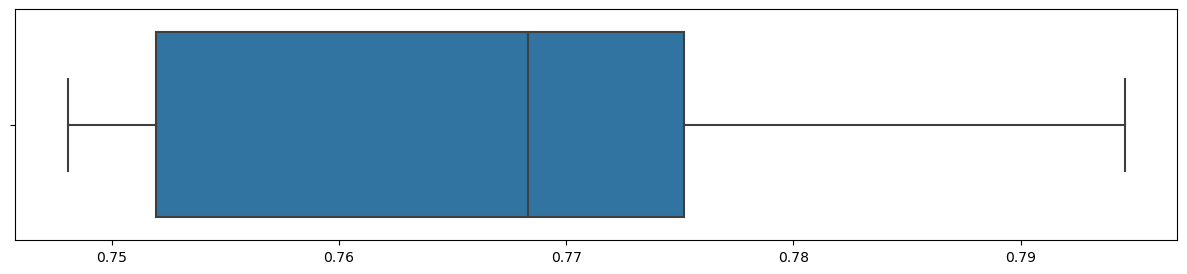

In [315]:


cross_vall = cross_val_score(knk, train_data, train_target, cv=5)

np.set_printoptions(precision=4)
print("Значения правильности перекрестной проверки:",cross_vall)

plt.figure(figsize=(15,3))
ax = sns.boxplot(x=cross_vall);

In [321]:
param_grid = [{
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 20],
    'p': [1, 2, 3, 4, 5]
}]

grid = GridSearchCV(knk, param_grid, cv = 8)
grid.fit(X_train, y_train)

grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

,4,2,0,3,1,8,9,7,5,6,...,64,68,57,76,73,69,77,78,74,79
mean_fit_time,0.004044,0.002524,0.000579,0.001351,0.001966,0.000546,0.001858,0.003135,0.002707,0.001096,...,0.001115,0.002,0.000853,0.001903,0.001942,0.001975,0.002027,0.001476,0.002147,0.001451
std_fit_time,0.004708,0.005081,0.000857,0.001159,0.001273,0.00095,0.000903,0.003429,0.001074,0.001525,...,0.001392,0.000365,0.000985,0.000173,0.000425,0.000251,0.000137,0.000982,0.000374,0.002145
mean_score_time,0.006527,0.007433,0.007994,0.008872,0.007132,0.009874,0.007349,0.008498,0.006085,0.007889,...,0.012699,0.010126,0.012383,0.006071,0.009927,0.009909,0.010256,0.011375,0.009767,0.011327
std_score_time,0.00486,0.006028,0.005608,0.005729,0.005157,0.006424,0.004876,0.006429,0.001273,0.006216,...,0.00146,0.000364,0.001385,0.000455,0.000316,0.000381,0.000535,0.001638,0.000488,0.002604
param_n_neighbors,1,1,1,1,1,2,2,2,2,2,...,15,16,14,20,17,16,20,20,17,20
param_p,5,3,1,4,2,4,5,3,1,2,...,5,4,3,2,4,5,3,4,5,5
params,"{'n_neighbors': 1, 'p': 5}","{'n_neighbors': 1, 'p': 3}","{'n_neighbors': 1, 'p': 1}","{'n_neighbors': 1, 'p': 4}","{'n_neighbors': 1, 'p': 2}","{'n_neighbors': 2, 'p': 4}","{'n_neighbors': 2, 'p': 5}","{'n_neighbors': 2, 'p': 3}","{'n_neighbors': 2, 'p': 1}","{'n_neighbors': 2, 'p': 2}",...,"{'n_neighbors': 15, 'p': 5}","{'n_neighbors': 16, 'p': 4}","{'n_neighbors': 14, 'p': 3}","{'n_neighbors': 20, 'p': 2}","{'n_neighbors': 17, 'p': 4}","{'n_neighbors': 16, 'p': 5}","{'n_neighbors': 20, 'p': 3}","{'n_neighbors': 20, 'p': 4}","{'n_neighbors': 17, 'p': 5}","{'n_neighbors': 20, 'p': 5}"
split0_test_score,0.844961,0.844961,0.821705,0.837209,0.829457,0.72093,0.728682,0.713178,0.689922,0.697674,...,0.666667,0.674419,0.682171,0.682171,0.674419,0.666667,0.666667,0.674419,0.658915,0.682171
split1_test_score,0.906977,0.899225,0.914729,0.899225,0.914729,0.806202,0.813953,0.806202,0.782946,0.806202,...,0.674419,0.666667,0.682171,0.674419,0.674419,0.666667,0.666667,0.674419,0.666667,0.674419
split2_test_score,0.906977,0.922481,0.914729,0.914729,0.914729,0.852713,0.829457,0.860465,0.852713,0.852713,...,0.782946,0.790698,0.767442,0.813953,0.790698,0.782946,0.782946,0.782946,0.790698,0.775194


In [379]:
#Аналогично для чищенных данных
param_grid = [{
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 20],
    'p': [1, 2, 3, 4, 5]
}]

grid_1 = GridSearchCV(knk, param_grid, cv = 8)
grid_1.fit(X_train_1, y_train_1)

grid_result_1 = pd.DataFrame(grid_1.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result_1

,4,0,3,2,1,9,5,8,7,6,...,77,64,44,38,78,68,74,73,39,79
mean_fit_time,0.004421,0.003504,0.001233,0.00327,0.001173,0.001953,0.000857,0.003705,0.000399,0.00149,...,0.002038,0.002261,0.002382,0.002505,0.00369,0.001189,0.002595,0.004241,0.002716,0.004337
std_fit_time,0.006606,0.004813,0.001161,0.004647,0.001257,0.005168,0.001153,0.004689,0.000785,0.001629,...,0.002349,0.005478,0.005146,0.005069,0.00531,0.0012,0.005078,0.00499,0.00505,0.006577
mean_score_time,0.007065,0.005147,0.007486,0.008995,0.006143,0.007042,0.006267,0.009165,0.007973,0.008074,...,0.010878,0.009399,0.010249,0.008778,0.009037,0.010979,0.008803,0.010894,0.00837,0.007661
std_score_time,0.007881,0.005192,0.007512,0.006077,0.007643,0.007291,0.006053,0.005696,0.006808,0.007392,...,0.004343,0.007231,0.007366,0.005866,0.004679,0.00612,0.006954,0.006334,0.008669,0.006375
param_n_neighbors,1,1,1,1,1,2,2,2,2,2,...,20,15,9,8,20,16,17,17,8,20
param_p,5,1,4,3,2,5,1,4,3,2,...,3,5,5,4,4,4,5,4,5,5
params,"{'n_neighbors': 1, 'p': 5}","{'n_neighbors': 1, 'p': 1}","{'n_neighbors': 1, 'p': 4}","{'n_neighbors': 1, 'p': 3}","{'n_neighbors': 1, 'p': 2}","{'n_neighbors': 2, 'p': 5}","{'n_neighbors': 2, 'p': 1}","{'n_neighbors': 2, 'p': 4}","{'n_neighbors': 2, 'p': 3}","{'n_neighbors': 2, 'p': 2}",...,"{'n_neighbors': 20, 'p': 3}","{'n_neighbors': 15, 'p': 5}","{'n_neighbors': 9, 'p': 5}","{'n_neighbors': 8, 'p': 4}","{'n_neighbors': 20, 'p': 4}","{'n_neighbors': 16, 'p': 4}","{'n_neighbors': 17, 'p': 5}","{'n_neighbors': 17, 'p': 4}","{'n_neighbors': 8, 'p': 5}","{'n_neighbors': 20, 'p': 5}"
split0_test_score,0.837209,0.821705,0.829457,0.829457,0.821705,0.705426,0.697674,0.697674,0.697674,0.689922,...,0.697674,0.682171,0.674419,0.674419,0.705426,0.689922,0.682171,0.682171,0.674419,0.705426
split1_test_score,0.914729,0.922481,0.906977,0.906977,0.922481,0.806202,0.782946,0.79845,0.79845,0.806202,...,0.682171,0.689922,0.674419,0.682171,0.674419,0.666667,0.674419,0.674419,0.674419,0.674419
split2_test_score,0.906977,0.914729,0.906977,0.914729,0.914729,0.829457,0.852713,0.844961,0.852713,0.844961,...,0.79845,0.79845,0.829457,0.852713,0.79845,0.79845,0.806202,0.813953,0.852713,0.79845


In [381]:
grid.best_estimator_

KNeighborsClassifier(n_neighbors=1, p=5)

In [383]:
grid_1.best_estimator_

KNeighborsClassifier(n_neighbors=1, p=5)

In [385]:
#Попробуем разные методы препроцессинга для выявления лучшего

#  Стандартизация (StandardScaler)
scaler_standard = StandardScaler()
scaler_standard.fit(X_train)  # Рассчитываем среднее и дисперсию по тренировочным данным

X_train_standard = scaler_standard.transform(X_train)  # Применяем масштабирование к тренировочным данным
X_test_standard = scaler_standard.transform(X_test)    # Применяем те же параметры к тестовым данным

# Применим модель классификации
knn_standard = KNeighborsClassifier(n_neighbors=1, p=5)
knn_standard.fit(X_train_standard, y_train)

# Оценим результат
y_pred_train_standard = knn_standard.predict(X_train_standard)
y_pred_test_standard = knn_standard.predict(X_test_standard)
print("StandardScaler:")
print("Точность на тренировочных данных: {:.3f}".format(accuracy_score(y_train, y_pred_train_standard)))
print("Точность на тестовых данных: {:.3f}".format(accuracy_score(y_test, y_pred_test_standard)))


# Нормализация (MinMaxScaler)
scaler_minmax = MinMaxScaler()
scaler_minmax.fit(X_train)  # Рассчитываем min и max значения по тренировочным данным

X_train_minmax = scaler_minmax.transform(X_train)  # Применяем нормализацию к тренировочным данным
X_test_minmax = scaler_minmax.transform(X_test)    # Применяем те же параметры к тестовым данным

# Применим модель классификации
knn_minmax = KNeighborsClassifier(n_neighbors=1, p=5)
knn_minmax.fit(X_train_minmax, y_train)

# Оценим результат
y_pred_train_minmax = knn_minmax.predict(X_train_minmax)
y_pred_test_minmax = knn_minmax.predict(X_test_minmax)
print("\nMinMaxScaler:")
print("Точность на тренировочных данных: {:.3f}".format(accuracy_score(y_train, y_pred_train_minmax)))
print("Точность на тестовых данных: {:.3f}".format(accuracy_score(y_test, y_pred_test_minmax)))


# Масштабирование, устойчивое к выбросам (RobustScaler)
scaler_robust = RobustScaler()
scaler_robust.fit(X_train)  # Рассчитываем медиану и интерквартильный размах по тренировочным данным

X_train_robust = scaler_robust.transform(X_train)  # Применяем устойчивое масштабирование к тренировочным данным
X_test_robust = scaler_robust.transform(X_test)    # Применяем те же параметры к тестовым данным

# Применим модель классификации
knn_robust = KNeighborsClassifier(n_neighbors=1, p=5)
knn_robust.fit(X_train_robust, y_train)

# Оценим результат
y_pred_train_robust = knn_robust.predict(X_train_robust)
y_pred_test_robust = knn_robust.predict(X_test_robust)
print("\nRobustScaler:")
print("Точность на тренировочных данных: {:.3f}".format(accuracy_score(y_train, y_pred_train_robust)))
print("Точность на тестовых данных: {:.3f}".format(accuracy_score(y_test, y_pred_test_robust)))


# Нормализация по строкам (Normalizer)
scaler_normalizer = Normalizer()
scaler_normalizer.fit(X_train)  # Рассчитываем нормализацию по строкам (это не всегда нужно)

X_train_normalized = scaler_normalizer.transform(X_train)  # Применяем нормализацию к тренировочным данным
X_test_normalized = scaler_normalizer.transform(X_test)    # Применяем те же параметры к тестовым данным

# Применим модель классификации
knn_normalized = KNeighborsClassifier(n_neighbors=1, p=5)
knn_normalized.fit(X_train_normalized, y_train)

# Оценим результат
y_pred_train_normalized = knn_normalized.predict(X_train_normalized)
y_pred_test_normalized = knn_normalized.predict(X_test_normalized)
print("\nNormalizer:")
print("Точность на тренировочных данных: {:.3f}".format(accuracy_score(y_train, y_pred_train_normalized)))
print("Точность на тестовых данных: {:.3f}".format(accuracy_score(y_test, y_pred_test_normalized)))

#На удивление устойчивый к выбросам RobustScaler оказался неэффективным => из всего ставляем MinMaxScaler
#Модель явно переобучилась, но судя по тестовому набору данных всё не так плохо

StandardScaler:
Точность на тренировочных данных: 1.000
Точность на тестовых данных: 0.923

MinMaxScaler:
Точность на тренировочных данных: 1.000
Точность на тестовых данных: 0.946

RobustScaler:
Точность на тренировочных данных: 1.000
Точность на тестовых данных: 0.923

Normalizer:
Точность на тренировочных данных: 1.000
Точность на тестовых данных: 0.931


In [389]:
#Попробуем разные методы препроцессинга для выявления лучшего на чищеном трейне

#  Стандартизация (StandardScaler)
scaler_standard = StandardScaler()
scaler_standard.fit(X_train_1)  # Рассчитываем среднее и дисперсию по тренировочным данным

X_train_standard_1 = scaler_standard.transform(X_train_1)  # Применяем масштабирование к тренировочным данным
X_test_standard_1 = scaler_standard.transform(X_test_1)    # Применяем те же параметры к тестовым данным

# Применим модель классификации
knn_standard_1 = KNeighborsClassifier(n_neighbors=1, p=5)
knn_standard_1.fit(X_train_standard_1, y_train_1)

# Оценим результат
y_pred_train_standard_1 = knn_standard_1.predict(X_train_standard_1)
y_pred_test_standard_1 = knn_standard_1.predict(X_test_standard_1)
print("StandardScaler:")
print("Точность на тренировочных данных: {:.3f}".format(accuracy_score(y_train_1, y_pred_train_standard_1)))
print("Точность на тестовых данных: {:.3f}".format(accuracy_score(y_test_1, y_pred_test_standard_1)))


# Нормализация (MinMaxScaler)
scaler_minmax_1 = MinMaxScaler()
scaler_minmax_1.fit(X_train_1)  # Рассчитываем min и max значения по тренировочным данным

X_train_minmax_1 = scaler_minmax_1.transform(X_train_1)  # Применяем нормализацию к тренировочным данным
X_test_minmax_1 = scaler_minmax_1.transform(X_test_1)    # Применяем те же параметры к тестовым данным

# Применим модель классификации
knn_minmax_1 = KNeighborsClassifier(n_neighbors=1, p=5)
knn_minmax_1.fit(X_train_minmax_1, y_train_1)

# Оценим результат
y_pred_train_minmax_1 = knn_minmax_1.predict(X_train_minmax_1)
y_pred_test_minmax_1 = knn_minmax_1.predict(X_test_minmax_1)
print("\nMinMaxScaler:")
print("Точность на тренировочных данных: {:.3f}".format(accuracy_score(y_train_1, y_pred_train_minmax_1)))
print("Точность на тестовых данных: {:.3f}".format(accuracy_score(y_test_1, y_pred_test_minmax_1)))


# Масштабирование, устойчивое к выбросам (RobustScaler)
scaler_robust_1 = RobustScaler()
scaler_robust_1.fit(X_train_1)  # Рассчитываем медиану и интерквартильный размах по тренировочным данным

X_train_robust_1 = scaler_robust_1.transform(X_train_1)  # Применяем устойчивое масштабирование к тренировочным данным
X_test_robust_1 = scaler_robust_1.transform(X_test_1)    # Применяем те же параметры к тестовым данным

# Применим модель классификации
knn_robust_1 = KNeighborsClassifier(n_neighbors=1, p=5)
knn_robust_1.fit(X_train_robust_1, y_train_1)

# Оценим результат
y_pred_train_robust_1 = knn_robust_1.predict(X_train_robust_1)
y_pred_test_robust_1 = knn_robust_1.predict(X_test_robust_1)
print("\nRobustScaler:")
print("Точность на тренировочных данных: {:.3f}".format(accuracy_score(y_train_1, y_pred_train_robust_1)))
print("Точность на тестовых данных: {:.3f}".format(accuracy_score(y_test_1, y_pred_test_robust_1)))


# Нормализация по строкам (Normalizer)
scaler_normalizer_1 = Normalizer()
scaler_normalizer_1.fit(X_train_1)  # Рассчитываем нормализацию по строкам (это не всегда нужно)

X_train_normalized_1 = scaler_normalizer_1.transform(X_train_1)  # Применяем нормализацию к тренировочным данным
X_test_normalized_1 = scaler_normalizer_1.transform(X_test_1)    # Применяем те же параметры к тестовым данным

# Применим модель классификации
knn_normalized_1 = KNeighborsClassifier(n_neighbors=1, p=5)
knn_normalized_1.fit(X_train_normalized_1, y_train_1)

# Оценим результат
y_pred_train_normalized_1 = knn_normalized_1.predict(X_train_normalized_1)
y_pred_test_normalized_1 = knn_normalized_1.predict(X_test_normalized_1)
print("\nNormalizer:")
print("Точность на тренировочных данных: {:.3f}".format(accuracy_score(y_train_1, y_pred_train_normalized_1)))
print("Точность на тестовых данных: {:.3f}".format(accuracy_score(y_test_1, y_pred_test_normalized_1)))

#На удивление устойчивый к выбросам RobustScaler оказался неэффективным => из всего ставляем MinMaxScaler
#Модель явно переобучилась, но судя по тестовому набору данных всё не так плохо

StandardScaler:
Точность на тренировочных данных: 1.000
Точность на тестовых данных: 0.946

MinMaxScaler:
Точность на тренировочных данных: 1.000
Точность на тестовых данных: 0.954

RobustScaler:
Точность на тренировочных данных: 1.000
Точность на тестовых данных: 0.938

Normalizer:
Точность на тренировочных данных: 1.000
Точность на тестовых данных: 0.931


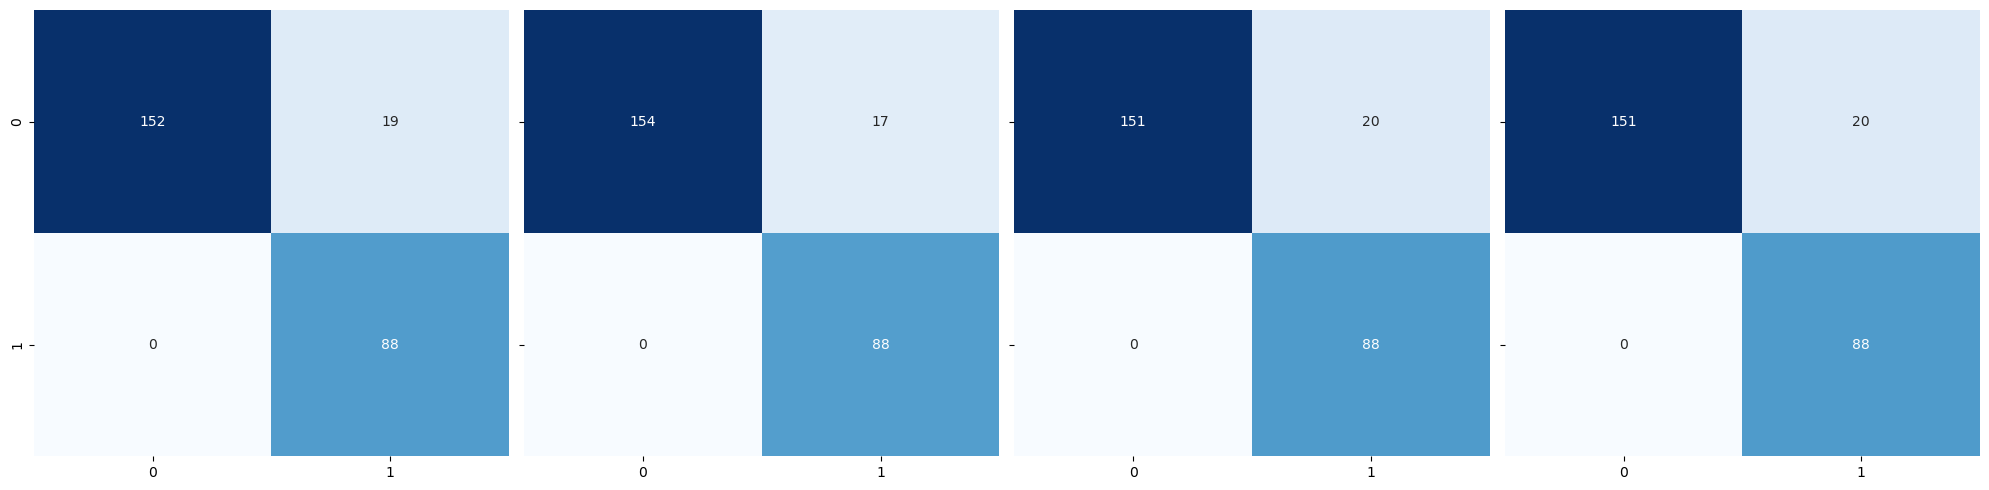

In [325]:
#матрицы ошибок как в семинаре, наверное они нам что-то скажут

matrix_1=confusion_matrix(y_test,y_pred_test_standard)
matrix_2=confusion_matrix(y_test,y_pred_test_minmax)
matrix_3=confusion_matrix(y_test,y_pred_test_robust)
matrix_4=confusion_matrix(y_test,y_pred_test_normalized)


fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20, 5))  # Указываем 4 графика по горизонтали

ax = plt.subplot(1, 4, 1)  # Первый график
sns.heatmap(matrix_1, annot=True, fmt='g', cbar=None, cmap="Blues")

ax = plt.subplot(1, 4, 2)  # Второй график
sns.heatmap(matrix_2, annot=True, fmt='g', cbar=None, cmap="Blues")

ax = plt.subplot(1, 4, 3)  # Третий график
sns.heatmap(matrix_3, annot=True, fmt='g', cbar=None, cmap="Blues")

ax = plt.subplot(1, 4, 4)  # Четвертый график
sns.heatmap(matrix_4, annot=True, fmt='g', cbar=None, cmap="Blues")

plt.tight_layout() 
plt.show()


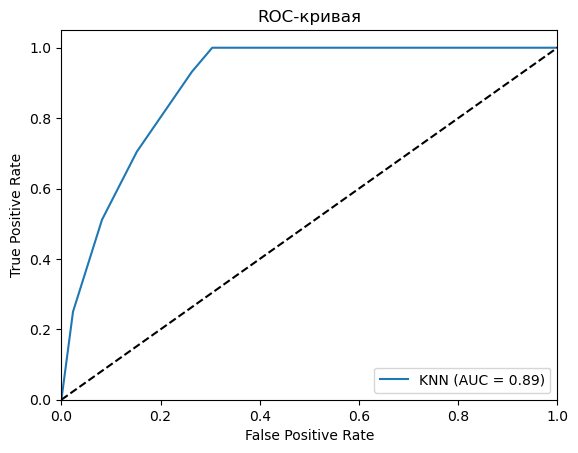

AUC: 0.8942052099946837


In [326]:
#Для верности построим rog auc
y_proba = knk.predict_proba(X_test)[:, 1]  # Для бинарной классификации берем вероятности класса 1

# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Вычисление AUC
roc_auc = roc_auc_score(y_test, y_proba)

# Построение графика ROC-кривой
plt.figure()
plt.plot(fpr, tpr, label='KNN (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Диагональная линия (случайное угадывание)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

print("AUC:", roc_auc)

In [327]:
##Логистическая регрессия
pipe = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('clf',           LogisticRegression())])

# n_splits = 10, random_state = 42 дают не удачную комбинацию и это хорошо для разбора ошибок решетки
cv = StratifiedShuffleSplit(test_size = .3, train_size = .6, n_splits = 10
                            , random_state = 42)
scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler(), Normalizer()]

param_grid =[
    {'preprocessing': scaling,'clf__penalty': ['l2'], 
         'clf__solver': ['newton-cg' ,'lbfgs', 'liblinear', 'sag', 'saga']},
    {'preprocessing': scaling,'clf__penalty': ['l1'], 
         'clf__solver': ['liblinear']},
    {'preprocessing': scaling,'clf__penalty': [None], 
         'clf__solver': ['lbfgs','newton-cg']}
    ]

grid = GridSearchCV(pipe, param_grid, cv = cv, return_train_score = True)
grid.fit(X_train, y_train)
grid    

D:\anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anacond

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.3,
            train_size=0.6),
             estimator=Pipeline(steps=[('preprocessing', MinMaxScaler()),
                                       ('clf', LogisticRegression())]),
             param_grid=[{'clf__penalty': ['l2'],
                          'clf__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                          'sag', 'saga'],
                          'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler(), Normalizer()]},
                         {'clf__penalty': ['l1'], 'clf__solver': ['liblinear'],
                          'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler(), Normalizer()]},
                         {'clf__penalty': [None],
                          'clf__solver': ['lbfgs', 'newton-cg'],
                          'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler(), Normalizer()]}],
             return_train_score=True)

In [328]:
grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

,18,2,14,10,22,6,24,25,26,28,...,16,4,31,27,23,11,7,3,15,19
mean_fit_time,0.011933,0.006649,0.008388,0.005016,0.00461,0.00732,0.007284,0.00368,0.008441,0.007003,...,0.003978,0.005411,0.007227,0.010588,0.005157,0.002788,0.005314,0.00423,0.00471,0.005113
std_fit_time,0.003412,0.001001,0.002393,0.003201,0.005964,0.001715,0.00661,0.005616,0.007116,0.007893,...,0.000505,0.002637,0.005802,0.00852,0.00585,0.002447,0.000727,0.002867,0.001655,0.004251
mean_score_time,0.000791,0.003151,0.00201,0.001673,0.000439,0.002956,0.000611,0.001747,0.000672,0.000465,...,0.001296,0.0015,0.001958,0.001999,0.000347,0.000972,0.001517,0.0015,0.001691,0.000625
std_score_time,0.000648,0.002371,0.002698,0.002714,0.000716,0.003258,0.000634,0.00466,0.000828,0.000739,...,0.000401,0.002719,0.004606,0.004726,0.000533,0.000945,0.000379,0.00277,0.001937,0.000648
param_clf__penalty,l2,l2,l2,l2,l1,l2,None,None,None,None,...,l2,l2,None,None,l1,l2,l2,l2,l2,l2
param_clf__solver,saga,newton-cg,sag,liblinear,liblinear,lbfgs,lbfgs,lbfgs,lbfgs,newton-cg,...,saga,lbfgs,newton-cg,lbfgs,liblinear,liblinear,lbfgs,newton-cg,sag,saga
param_preprocessing,RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),MinMaxScaler(),StandardScaler(),RobustScaler(),MinMaxScaler(),...,MinMaxScaler(),MinMaxScaler(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer()
params,"{'clf__penalty': 'l2', 'clf__solver': 'saga', ...","{'clf__penalty': 'l2', 'clf__solver': 'newton-...","{'clf__penalty': 'l2', 'clf__solver': 'sag', '...","{'clf__penalty': 'l2', 'clf__solver': 'libline...","{'clf__penalty': 'l1', 'clf__solver': 'libline...","{'clf__penalty': 'l2', 'clf__solver': 'lbfgs',...","{'clf__penalty': None, 'clf__solver': 'lbfgs',...","{'clf__penalty': None, 'clf__solver': 'lbfgs',...","{'clf__penalty': None, 'clf__solver': 'lbfgs',...","{'clf__penalty': None, 'clf__solver': 'newton-...",...,"{'clf__penalty': 'l2', 'clf__solver': 'saga', ...","{'clf__penalty': 'l2', 'clf__solver': 'lbfgs',...","{'clf__penalty': None, 'clf__solver': 'newton-...","{'clf__penalty': None, 'clf__solver': 'lbfgs',...","{'clf__penalty': 'l1', 'clf__solver': 'libline...","{'clf__penalty': 'l2', 'clf__solver': 'libline...","{'clf__penalty': 'l2', 'clf__solver': 'lbfgs',...","{'clf__penalty': 'l2', 'clf__solver': 'newton-...","{'clf__penalty': 'l2', 'clf__solver': 'sag', '...","{'clf__penalty': 'l2', 'clf__solver': 'saga', ..."
split0_test_score,0.83871,0.83871,0.83871,0.83871,0.835484,0.83871,0.832258,0.829032,0.829032,0.829032,...,0.806452,0.806452,0.832258,0.809677,0.712903,0.729032,0.729032,0.729032,0.729032,0.729032
split1_test_score,0.832258,0.825806,0.825806,0.822581,0.819355,0.825806,0.829032,0.829032,0.829032,0.829032,...,0.816129,0.816129,0.825806,0.822581,0.722581,0.729032,0.729032,0.729032,0.729032,0.729032


<Axes: >

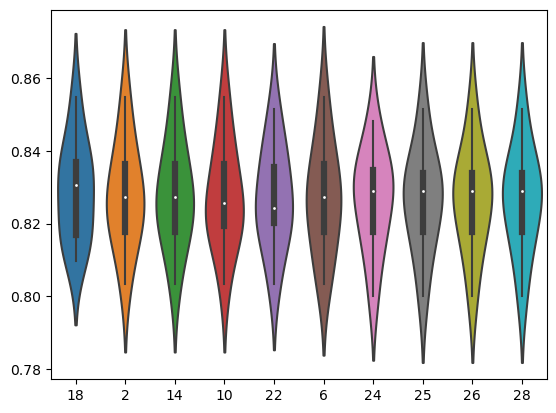

In [329]:
mask = grid_result.index[grid_result.index.str.endswith("_test_score")][:-3]
tabl = grid_result.loc[mask].iloc[:,:10]
sns.violinplot(data=tabl)

In [330]:
grid.cv_results_['params'][24]

{'clf__penalty': None, 'clf__solver': 'lbfgs', 'preprocessing': MinMaxScaler()}

In [331]:
pipe_best = make_pipeline(MinMaxScaler(), LogisticRegression(solver = 'lbfgs', penalty = None) )
pipe_best.fit(X_train,y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression(penalty=None))])

In [332]:
grid.best_estimator_

Pipeline(steps=[('preprocessing', RobustScaler()),
                ('clf', LogisticRegression(solver='saga'))])

In [333]:
y_pred_best = pipe_best.predict(X_test)
print(classification_report(y_test, y_pred_best))
#критически низкая точность

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       171
           1       0.70      0.65      0.67        88

    accuracy                           0.79       259
   macro avg       0.76      0.75      0.76       259
weighted avg       0.78      0.79      0.79       259



In [334]:
#Наивный байес
pipe = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('clf',           GaussianNB())])

cv = StratifiedShuffleSplit(test_size = .3, train_size = .6, n_splits = 5, random_state = 42)
scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler(), Normalizer()]

param_grid =[
    {'preprocessing': scaling, 
     'clf': [GaussianNB()]}
    ]

grid = GridSearchCV(pipe, param_grid, cv = cv)
grid.fit(X_train, y_train)
grid 

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.3,
            train_size=0.6),
             estimator=Pipeline(steps=[('preprocessing', MinMaxScaler()),
                                       ('clf', GaussianNB())]),
             param_grid=[{'clf': [GaussianNB()],
                          'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler(), Normalizer()]}])

In [335]:
grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

,0,1,2,3
mean_fit_time,0.004589,0.002727,0.00625,0.003125
std_fit_time,0.001179,0.000199,0.007655,0.00625
mean_score_time,0.001384,0.001385,0.0,0.0
std_score_time,0.00056,0.000806,0.0,0.0
param_clf,GaussianNB(),GaussianNB(),GaussianNB(),GaussianNB()
param_preprocessing,MinMaxScaler(),StandardScaler(),RobustScaler(),Normalizer()
params,"{'clf': GaussianNB(), 'preprocessing': MinMaxS...","{'clf': GaussianNB(), 'preprocessing': Standar...","{'clf': GaussianNB(), 'preprocessing': RobustS...","{'clf': GaussianNB(), 'preprocessing': Normali..."
split0_test_score,0.812903,0.812903,0.812903,0.722581
split1_test_score,0.780645,0.780645,0.780645,0.729032
split2_test_score,0.767742,0.767742,0.767742,0.754839


In [336]:
print(grid.best_estimator_)

Pipeline(steps=[('preprocessing', MinMaxScaler()), ('clf', GaussianNB())])


In [355]:
pipe_best = Pipeline(steps=[('preprocessing', Normalizer()), ('clf', GaussianNB())])
pipe_best.fit(X_train,y_train)
y_best = pipe_best.predict(X_test)

print(classification_report(y_test, y_best))
#сделал как на паре, результат конечно не очень и с этим ничего не поделаешь

              precision    recall  f1-score   support

           0       0.77      0.83      0.80       171
           1       0.61      0.51      0.56        88

    accuracy                           0.72       259
   macro avg       0.69      0.67      0.68       259
weighted avg       0.71      0.72      0.72       259

